# Grid test data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 20:29:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/20 20:29:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# get dataframes
gcs_path = "gs://dsgt-clef-plantclef-2024"
data_path = "data/parquet_files/PlantCLEF2024_test"

# paths to dataframe
test_path = f"{gcs_path}/{data_path}"
# read data
test_df = spark.read.parquet(test_path)
# show
test_df.show(n=5, truncate=50)

+-------------------------------------------+------------------------+--------------------------------------------------+
|                                       path|              image_name|                                              data|
+-------------------------------------------+------------------------+--------------------------------------------------+
| /PlantCLEF2024test/CBN-Pla-B4-20160728.jpg| CBN-Pla-B4-20160728.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
| /PlantCLEF2024test/CBN-Pla-D3-20130808.jpg| CBN-Pla-D3-20130808.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
|/PlantCLEF2024test/CBN-PdlC-E4-20150701.jpg|CBN-PdlC-E4-20150701.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
| /PlantCLEF2024test/CBN-Pla-F5-20150901.jpg| CBN-Pla-F5-20150901.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
| /PlantCLEF2024test/CBN-Pla-D1-20180724.jpg| CBN-Pla-D1-20180724.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
+-----------------------

In [4]:
import io
from PIL import Image
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, BinaryType

In [34]:
# Define the function to split image into grid
def split_into_grid(image_binary, grid_size):
    image = Image.open(io.BytesIO(image_binary))
    w, h = image.size
    grid_w, grid_h = w // grid_size, h // grid_size
    patches = []
    for j in range(grid_size):
        for i in range(grid_size):
            left = i * grid_w
            upper = j * grid_h
            right = left + grid_w
            lower = upper + grid_h
            crop_image = image.crop((left, upper, right, lower))
            byte_arr = io.BytesIO()
            crop_image.save(byte_arr, format="PNG")
            patches.append(byte_arr.getvalue())
    return patches


def process_test_grid_df(df: DataFrame) -> DataFrame:
    # Register the UDF
    split_into_grid_udf = F.udf(
        lambda img: split_into_grid(img, 3), ArrayType(BinaryType())
    )

    # Apply the UDF to the dataframe
    df = df.withColumn("patches", split_into_grid_udf(F.col("data")))

    # Explode the dataframe to get each patch in a separate row
    exploded_df = df.select(
        F.col("image_name"), F.posexplode("patches").alias("patch_number", "data")
    )

    # Create the final dataframe
    final_df = exploded_df.select("image_name", "patch_number", "data")
    return final_df

In [35]:
# get subset of data
test_limit_df = test_df.limit(10).cache()
# process dataframe
grid_df = process_test_grid_df(df=test_limit_df).cache()
grid_df.show(n=5, truncate=50)

24/05/20 20:51:04 WARN CacheManager: Asked to cache already cached data.


+-----------------------+------------+--------------------------------------------------+
|             image_name|patch_number|                                              data|
+-----------------------+------------+--------------------------------------------------+
|CBN-Pla-B4-20160728.jpg|           0|[89 50 4E 47 0D 0A 1A 0A 00 00 00 0D 49 48 44 5...|
|CBN-Pla-B4-20160728.jpg|           1|[89 50 4E 47 0D 0A 1A 0A 00 00 00 0D 49 48 44 5...|
|CBN-Pla-B4-20160728.jpg|           2|[89 50 4E 47 0D 0A 1A 0A 00 00 00 0D 49 48 44 5...|
|CBN-Pla-B4-20160728.jpg|           3|[89 50 4E 47 0D 0A 1A 0A 00 00 00 0D 49 48 44 5...|
|CBN-Pla-B4-20160728.jpg|           4|[89 50 4E 47 0D 0A 1A 0A 00 00 00 0D 49 48 44 5...|
+-----------------------+------------+--------------------------------------------------+
only showing top 5 rows



In [36]:
import numpy as np
import matplotlib.pyplot as plt


def plot_images_from_binary(df, data_col: str, image_col: str, grid_size=(3, 3)):
    """
    Display images in a grid with binomial names as labels.

    :param df: DataFrame with the embeddings data.
    :param data_col: Name of the data column.
    :param image_col: Name of the species being displayed as image labels.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Collect binary image data from DataFrame
    subset_df = df.limit(rows * cols).collect()
    image_data_list = [row[data_col] for row in subset_df]
    image_names = [row[image_col] for row in subset_df]

    # Create a matplotlib subplot with the specified grid size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12), dpi=80)

    # Flatten the axes array for easy iteration if it's 2D
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax, binary_data, name in zip(axes, image_data_list, image_names):
        # Convert binary data to an image and display it
        image = Image.open(io.BytesIO(binary_data))
        ax.imshow(image)
        # name = name.replace("_", " ")
        ax.set_xlabel(name)  # Set the binomial name as xlabel
        ax.xaxis.label.set_size(14)  # Set the font size for the xlabel
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

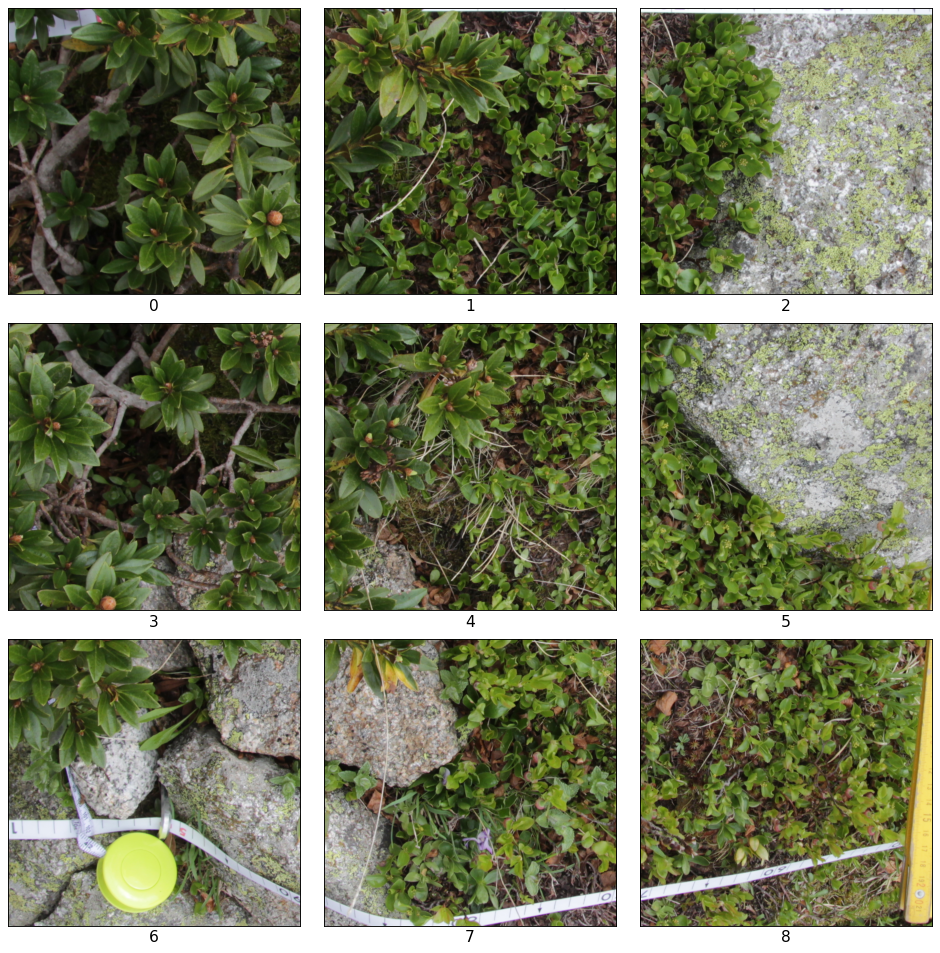

In [37]:
# Display the images in a grid with binomial names
ordered_grid_df = grid_df.orderBy("image_name").cache()
plot_images_from_binary(
    ordered_grid_df, data_col="data", image_col="patch_number", grid_size=(3, 3)
)

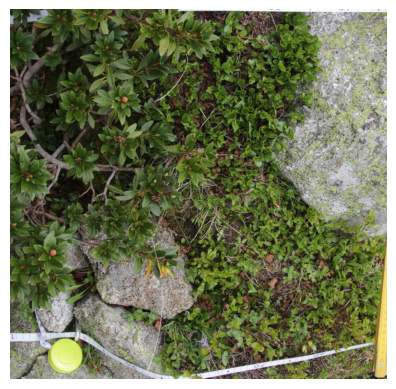

In [38]:
image_row = test_limit_df.where(
    F.col("image_name") == "CBN-PdlC-B5-20160705.jpg"
).collect()
image_binary = image_row[0]["data"]

# Convert the binary data to an image using PIL
image = Image.open(io.BytesIO(image_binary))

# Display the image using Matplotlib
plt.imshow(image)
plt.axis("off")  # Hide the axis
plt.show()

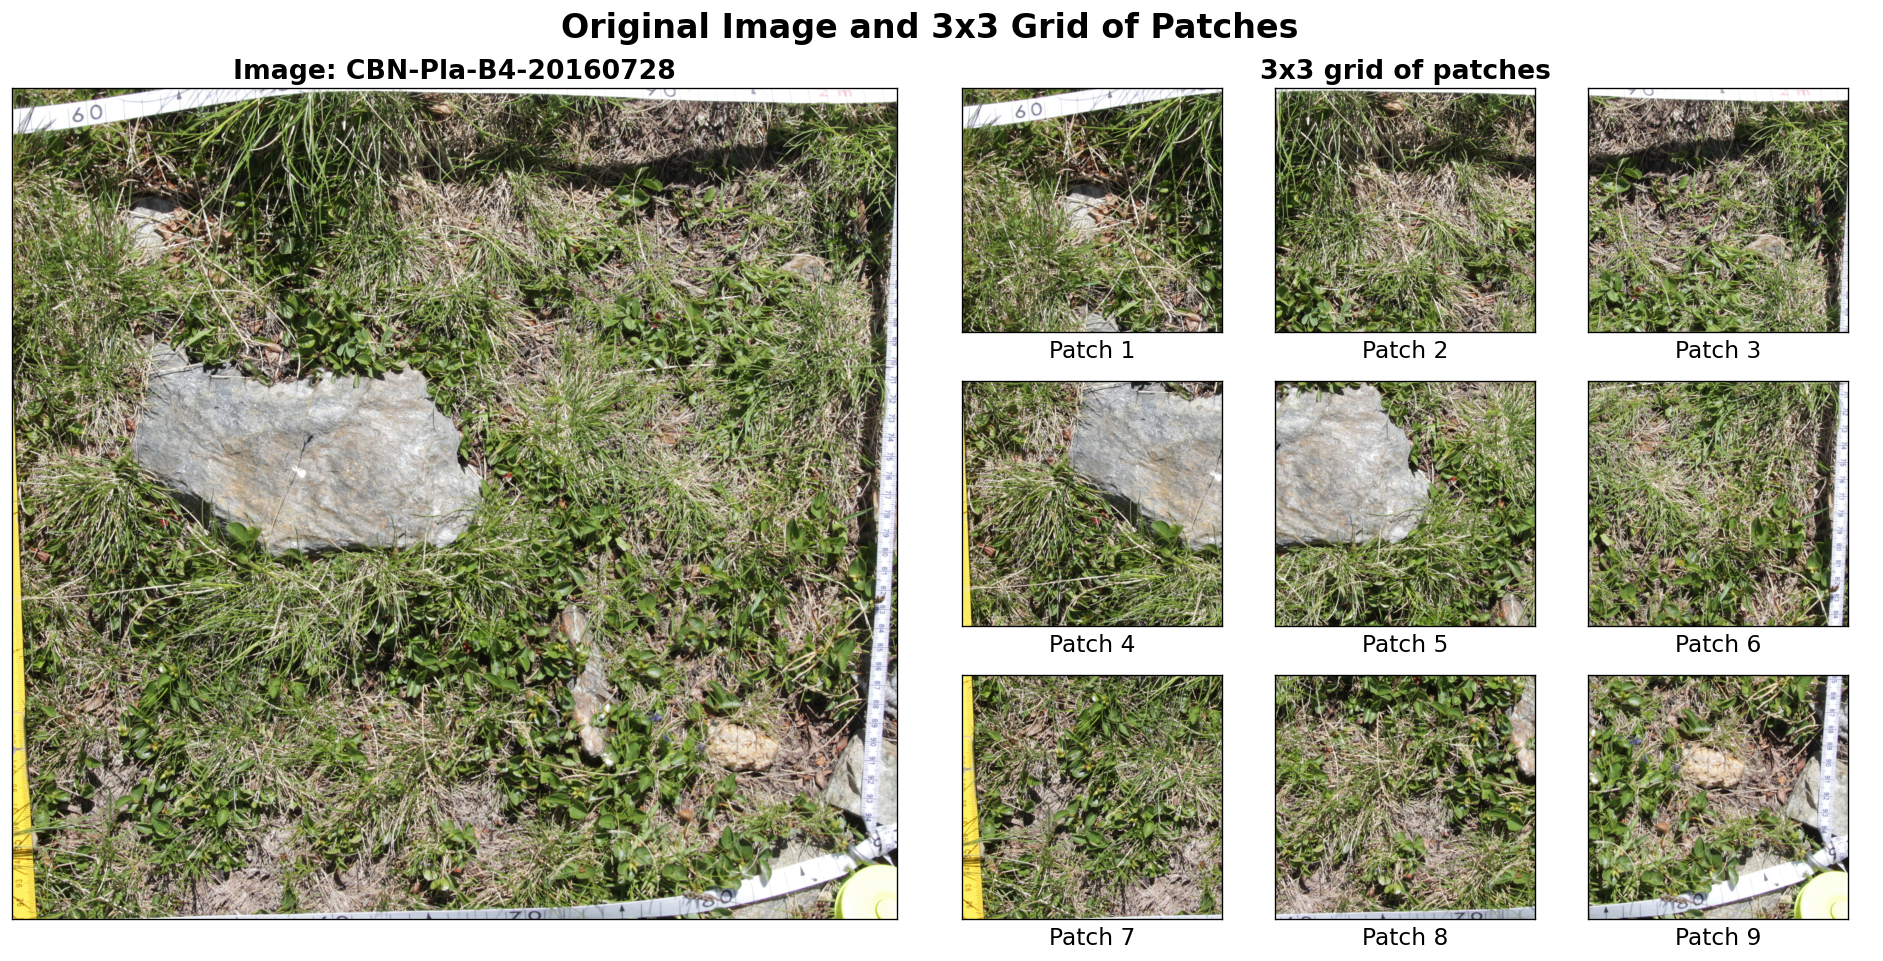

In [90]:
def split_into_grid(image_binary, grid_size):
    image = Image.open(io.BytesIO(image_binary))
    w, h = image.size
    grid_w, grid_h = w // grid_size, h // grid_size
    patches = []
    for j in range(grid_size):  # Iterate over rows first
        for i in range(grid_size):  # Iterate over columns second
            left = i * grid_w
            upper = j * grid_h
            right = left + grid_w
            lower = upper + grid_h
            crop_image = image.crop((left, upper, right, lower))
            byte_arr = io.BytesIO()
            crop_image.save(byte_arr, format="PNG")
            patches.append(byte_arr.getvalue())
    return patches


def plot_images_grid_from_binary(df, data_col: str, image_col: str, grid_size=(3, 3)):
    """
    Display images in a grid with binomial names as labels.

    :param df: DataFrame with the embeddings data.
    :param data_col: Name of the data column.
    :param image_col: Name of the species being displayed as image labels.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Collect binary image data from DataFrame
    subset_df = df.limit(1).collect()
    image_data = subset_df[0][data_col]
    image_names = subset_df[0][image_col]

    # Split the image into patches
    patches = split_into_grid(image_data, grid_size[0])

    # Create a matplotlib subplot with the specified grid size
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=120)
    fig.suptitle("Original Image and 3x3 Grid of Patches", fontsize=20, weight="bold")

    # Plot the original image on the left
    ax_left = axes[0]
    image = Image.open(io.BytesIO(image_data))
    ax_left.imshow(image)
    image_title = image_names.replace(".jpg", "")
    ax_left.set_title(f"Image: {image_title}", fontsize=16, weight="bold")
    ax_left.set_xticks([])
    ax_left.set_yticks([])

    # Plot the 3x3 grid of patches on the right
    gs = fig.add_gridspec(1, 2)[1]
    grid_axes = gs.subgridspec(rows, cols)

    for idx, patch_data in enumerate(patches):
        row, col = divmod(idx, cols)
        ax = fig.add_subplot(grid_axes[row, col])
        patch_image = Image.open(io.BytesIO(patch_data))
        ax.imshow(patch_image)
        ax.set_xlabel(f"Patch {idx+1}", fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])

    ax_right = axes[1]
    ax_right.set_title(
        f"{grid_size[0]}x{grid_size[1]} grid of patches", fontsize=16, weight="bold"
    )
    ax_right.set_xticks([])
    ax_right.set_yticks([])
    spines = ["top", "right", "bottom", "left"]
    for spine in spines:
        ax_right.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()


plot_images_grid_from_binary(
    test_limit_df, data_col="data", image_col="image_name", grid_size=(3, 3)
)